<a href="https://colab.research.google.com/github/arsalanmontazeri/Arsalan-Montazeri/blob/time-forecasting/time_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For displaying all of the columns in dataframes
pd.set_option('display.max_column',None)
# For data modeling
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
# For saving models
import pickle

In [ ]:
pd.set_option('display.max_column',None)

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
oil=pd.read_csv('oil.csv')
stores=pd.read_csv('stores.csv')
transaction=pd.read_csv('transactions.csv')
holiday=pd.read_csv('holidays_events.csv')

In [ ]:
train.shape

(3000888, 6)

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
train['date']=pd.to_datetime(train['date'])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [ ]:
train['family'].values

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', ..., 'PRODUCE',
       'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'], dtype=object)

In [ ]:
train.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


In [ ]:
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [ ]:
train.duplicated().sum()

0

In [ ]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
sales_per_store=train.groupby('store_nbr')['sales'].sum().reset_index()
promotion_per_store=train.groupby('store_nbr')['onpromotion'].sum().reset_index()


In [ ]:
stores.shape

(54, 5)

In [ ]:
sales_per_store.shape

(54, 2)

In [ ]:
stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [ ]:
stores.duplicated().sum()

0

In [ ]:
stores=pd.merge(stores,sales_per_store,on='store_nbr',how='right')

In [ ]:
stores=pd.merge(stores,promotion_per_store,on='store_nbr',how='right')

In [ ]:
stores.head()

,store_nbr,city,state,type,cluster,sales,onpromotion
0,1,Quito,Pichincha,D,13,1.414501e+07,138020
1,2,Quito,Pichincha,D,13,2.155739e+07,158149
2,3,Quito,Pichincha,D,8,5.048191e+07,177075
3,4,Quito,Pichincha,D,9,1.890970e+07,151932
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,1.559240e+07,149370


In [ ]:
stores['type'].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

In [ ]:
holiday.shape

(350, 6)

In [ ]:
holiday.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [ ]:
holiday.duplicated().sum()

0

In [ ]:
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
holiday['locale'].value_counts()

locale
National    166
Local       148
Regional     24
Name: count, dtype: int64

In [ ]:
holiday=holiday[holiday['transferred']==False]
train['holiday']=0
national_holiday=holiday[holiday['locale']=='National']
for date in national_holiday['date']:
  train.loc[train['date']==date,'holiday']=1
local_reginal_holiday=holiday[holiday['locale']!='National']
for index,row in local_reginal_holiday.iterrows():
  train.loc[train['date']==row['date'],'holiday']=1

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1
1,1,2013-01-01,1,BABY CARE,0.0,0,1
2,2,2013-01-01,1,BEAUTY,0.0,0,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,1
4,4,2013-01-01,1,BOOKS,0.0,0,1


In [ ]:
train.shape

(3000888, 7)

In [ ]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [ ]:
oil['date']=pd.to_datetime(oil['date'])
oil['dcoilwtico']=oil['dcoilwtico'].interpolate(method='linear')
oil['dcoilwtico']=oil['dcoilwtico'].fillna(method='bfill')

In [ ]:
oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


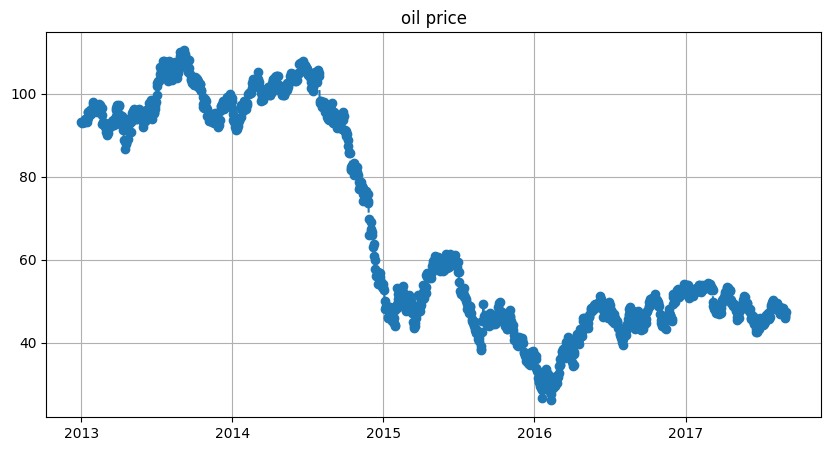

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(oil['date'],oil['dcoilwtico'],marker='o',linestyle='--')
plt.title('oil price')
plt.grid(True)

In [ ]:
transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
transaction.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [ ]:
transaction.duplicated().sum()

0

In [ ]:
total_transaction=transaction.groupby('store_nbr')['transactions'].sum().reset_index()

In [ ]:
stores=pd.merge(stores,total_transaction,on='store_nbr',how='right')

In [ ]:
stores.shape

(54, 8)

In [ ]:
sale=train.groupby('date')['sales'].sum().reset_index()
oil_merge=pd.merge(oil,sale['sales'],left_index=True,right_index=True)
oil_merge.head()

,date,dcoilwtico,sales
0,2013-01-01,93.14,2511.618999
1,2013-01-02,93.14,496092.417944
2,2013-01-03,92.97,361461.231124
3,2013-01-04,93.12,354459.677093
4,2013-01-07,93.20,477350.121229


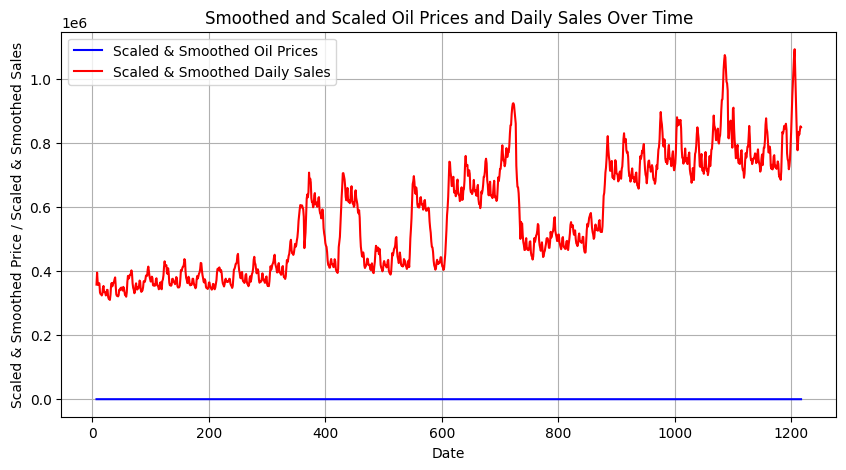

In [ ]:
from sklearn.preprocessing import MinMaxScaler
window_size = 8  # Choose an appropriate window size for smoothing
oil_merge['dcoilwtico_smooth'] =oil_merge['dcoilwtico'].rolling(window=window_size).mean()
oil_merge['sales_smooth'] = oil_merge['sales'].rolling(window=window_size).mean()
scaler=MinMaxScaler()

oil_merge_scale=oil_merge.copy()
oil_merge_scale[['dcoilwtico','sales']]=scaler.fit_transform(oil_merge_scale[['dcoilwtico','sales']])

plt.figure(figsize=(10, 5))
plt.plot(oil_merge_scale.index, oil_merge_scale['dcoilwtico_smooth'], linestyle='-', color='blue', label='Scaled & Smoothed Oil Prices')
plt.plot(oil_merge_scale.index, oil_merge_scale['sales_smooth'], linestyle='-', color='red', label='Scaled & Smoothed Daily Sales')
plt.title('Smoothed and Scaled Oil Prices and Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled & Smoothed Price / Scaled & Smoothed Sales')
plt.legend()
plt.grid(True)
plt.show()